In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]

import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from pikachu_dataset import load_data_pikachu
from torch import nn
from torch.utils.data import Dataset
device  = 'cuda' if torch.cuda.is_available() else 'cpu'


/home/i008/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
        if anchor_areas is not None:
            encoder = DataEncoder(anchor_areas=anchor_areas)
        else:
            encoder = DataEncoder()            
        self.encoder = encoder 
        
    def __len__(self):
        return 900
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
        
def down_sample(in_channels,out_channels):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                 nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1), 
                  nn.BatchNorm2d(out_channels), 
                  nn.ReLU(),
                  nn.MaxPool2d(2,2)
                 
                 )

class SimpleSSD(nn.Module):
    
    
    def __init__(self, n_cls=1, num_anchors=9):
        super(SimpleSSD, self).__init__()
        
        self.n_cls = n_cls
        self.num_anchors = num_anchors
        
        
        # Base CNN (think resnet/vgg or other base network)
        self.step1 = down_sample(3, 128)
        self.step2 = down_sample(128, 128)
        
        self.step3 = down_sample(128, 128)
        self.step4 = down_sample(128, 128)
        self.step5 = down_sample(128, 128)

        self.cls_head1 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, self.num_anchors *4, 3, padding=1)
        
        self.cls_head2 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head2 = nn.Conv2d(128,self.num_anchors * 4,3, padding=1)
        
        self.cls_head3 = nn.Conv2d(128, self.num_anchors * self.n_cls , 3, padding=1)
        self.bbox_head3 = nn.Conv2d(128, self.num_anchors * 4,3, padding=1)
        
        
    def forward(self, x):
        
        step1=self.step1(x)
        step2=self.step2(step1)

        step3=self.step3(step2)
        step4 = self.step4(step3)
        step5 = self.step5(step4)
        
        
        cls1 = self.cls_head1(step3)
        bbox1 = self.bbox_head1(step3)
        
        cls2 = self.cls_head2(step4)
        bbox2 = self.bbox_head2(step4)
        
        cls3 = self.cls_head3(step5)
        bbox3 = self.bbox_head3(step5) 
        
    
        cls1 = cls1.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls2 = cls2.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        cls3 = cls3.permute(0,2,3,1).contiguous().view(x.size(0), -1, self.n_cls)
        
        bbox1 = bbox1.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox2 = bbox2.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
        bbox3 = bbox3.permute(0,2,3,1).contiguous().view(x.size(0), -1, 4)
      
        cls_pred = torch.cat([cls1, cls2, cls3], dim=1)
        bbox_pred = torch.cat([bbox1, bbox2, bbox3], dim=1)
        
        return bbox_pred, cls_pred
                

    

In [5]:
pikachu_ds =PikachuDataset(anchor_areas=[30*30, 50*50, 90*90])
pikachu_dl = DataLoader(pikachu_ds, batch_size=2, collate_fn=pikachu_ds.collate_func)





In [6]:
model= SimpleSSD(1)
model = model.to(device)
criterion = FocalLoss(num_classes=1)

In [7]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
collect = []
for epoch in range(2):
    print(epoch)
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        optimizer.step()
#         print(total_loss)
        collect.append([total_loss.detach().cpu().numpy()])


0
clsloss: 3609.931640625 locloss: 66.78634643554688
clsloss: 3301.12109375 locloss: 48.62600326538086


/home/i008/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


clsloss: 3028.35009765625 locloss: 33.31591796875
clsloss: 2748.307373046875 locloss: 32.21175765991211
clsloss: 2597.1982421875 locloss: 12.979696273803711
clsloss: 2399.8818359375 locloss: 13.772682189941406
clsloss: 2225.2333984375 locloss: 13.487485885620117
clsloss: 2056.72998046875 locloss: 17.73982810974121
clsloss: 1999.9908447265625 locloss: 15.874136924743652
clsloss: 1830.16259765625 locloss: 11.540872573852539
clsloss: 1762.8233642578125 locloss: 15.271557807922363
clsloss: 1548.086669921875 locloss: 9.754561424255371
clsloss: 1410.8895263671875 locloss: 7.934166431427002
clsloss: 1499.6881103515625 locloss: 8.92227840423584
clsloss: 1346.9669189453125 locloss: 8.160893440246582
clsloss: 1197.88671875 locloss: 8.075016021728516
clsloss: 1159.389892578125 locloss: 8.210712432861328
clsloss: 1096.769287109375 locloss: 7.825828552246094
clsloss: 1029.5592041015625 locloss: 7.794591426849365
clsloss: 917.9388427734375 locloss: 11.259469985961914
clsloss: 743.348876953125 loclos

clsloss: 44.62898254394531 locloss: 2.706064224243164
clsloss: 63.629180908203125 locloss: 4.4011406898498535
clsloss: 36.70833969116211 locloss: 5.317288875579834
clsloss: 37.5893669128418 locloss: 4.391587257385254
clsloss: 48.00894546508789 locloss: 3.391925811767578
clsloss: 38.227970123291016 locloss: 3.182509660720825
clsloss: 33.00263214111328 locloss: 2.964634418487549
clsloss: 37.0369873046875 locloss: 4.604221820831299
clsloss: 37.95356750488281 locloss: 4.02227258682251
clsloss: 60.67411804199219 locloss: 6.470668315887451
clsloss: 59.06675720214844 locloss: 5.473023891448975
clsloss: 39.143096923828125 locloss: 2.845630645751953
clsloss: 54.91240310668945 locloss: 7.811932563781738
clsloss: 53.672481536865234 locloss: 5.56050968170166
clsloss: 50.182594299316406 locloss: 2.6844515800476074
clsloss: 40.58454132080078 locloss: 2.7492117881774902
clsloss: 59.50068664550781 locloss: 4.288639068603516
clsloss: 70.63460540771484 locloss: 3.1596479415893555
clsloss: 43.90461730957

clsloss: 27.014816284179688 locloss: 3.408282995223999
clsloss: 19.40439796447754 locloss: 2.457883358001709
clsloss: 23.38703727722168 locloss: 2.6272530555725098
clsloss: 15.636358261108398 locloss: 1.8134154081344604
clsloss: 22.479652404785156 locloss: 3.4173178672790527
clsloss: 21.547657012939453 locloss: 4.317198276519775
clsloss: 17.181581497192383 locloss: 2.1823463439941406
clsloss: 21.176788330078125 locloss: 2.6316354274749756
clsloss: 18.862079620361328 locloss: 3.190098285675049
clsloss: 23.39019775390625 locloss: 2.1865687370300293
clsloss: 23.44692611694336 locloss: 1.8049067258834839
clsloss: 23.473262786865234 locloss: 2.4849600791931152
clsloss: 26.78365135192871 locloss: 4.810274600982666
clsloss: 19.7938232421875 locloss: 2.2943825721740723
clsloss: 22.943618774414062 locloss: 2.8249382972717285
clsloss: 16.619234085083008 locloss: 3.2382164001464844
clsloss: 19.631351470947266 locloss: 2.644448757171631
clsloss: 19.222421646118164 locloss: 2.8453166484832764
clslo

clsloss: 16.04680633544922 locloss: 2.864936113357544
clsloss: 15.880359649658203 locloss: 2.3569388389587402
clsloss: 13.54191780090332 locloss: 2.090027332305908
clsloss: 19.136795043945312 locloss: 3.071957588195801
clsloss: 16.884944915771484 locloss: 3.1049556732177734
clsloss: 19.377891540527344 locloss: 2.9156911373138428
clsloss: 19.11962890625 locloss: 2.143139123916626
clsloss: 21.798507690429688 locloss: 3.010281562805176
clsloss: 13.35831069946289 locloss: 2.624269485473633
clsloss: 23.954086303710938 locloss: 1.7780523300170898
clsloss: 13.660295486450195 locloss: 2.7410430908203125
clsloss: 23.888803482055664 locloss: 4.145632266998291
clsloss: 18.799875259399414 locloss: 2.1742072105407715
clsloss: 13.06970500946045 locloss: 2.1791820526123047
clsloss: 12.837394714355469 locloss: 2.6666176319122314
clsloss: 17.02240753173828 locloss: 3.6072075366973877
clsloss: 20.460830688476562 locloss: 2.8222830295562744
clsloss: 14.12942123413086 locloss: 1.795789122581482
clsloss: 1

clsloss: 15.280078887939453 locloss: 2.6241159439086914
clsloss: 17.69936752319336 locloss: 1.97151517868042
clsloss: 16.381000518798828 locloss: 2.4849183559417725
clsloss: 12.677127838134766 locloss: 2.014327049255371
clsloss: 14.067132949829102 locloss: 2.877476930618286
clsloss: 11.352935791015625 locloss: 1.6263859272003174
clsloss: 11.648780822753906 locloss: 2.228228807449341
clsloss: 11.444646835327148 locloss: 1.4237546920776367
clsloss: 21.641849517822266 locloss: 3.043079137802124
clsloss: 11.0990571975708 locloss: 1.5348734855651855
clsloss: 14.218724250793457 locloss: 2.651798725128174
clsloss: 15.068973541259766 locloss: 2.4246273040771484
clsloss: 8.79509162902832 locloss: 2.0473923683166504
clsloss: 16.33263397216797 locloss: 1.665797233581543
clsloss: 10.709604263305664 locloss: 1.7952910661697388
clsloss: 16.795970916748047 locloss: 2.7427902221679688
clsloss: 15.465734481811523 locloss: 2.7616469860076904
clsloss: 15.465832710266113 locloss: 1.8032147884368896
clslos

clsloss: 21.168678283691406 locloss: 2.3511550426483154
clsloss: 10.216654777526855 locloss: 2.041320323944092
clsloss: 14.99783706665039 locloss: 3.02292799949646
clsloss: 16.073833465576172 locloss: 2.3662302494049072
clsloss: 14.642271041870117 locloss: 2.307445764541626
clsloss: 13.957906723022461 locloss: 2.3595449924468994
clsloss: 11.320606231689453 locloss: 2.1324479579925537
clsloss: 11.84393310546875 locloss: 1.9375728368759155
clsloss: 10.196850776672363 locloss: 2.0569474697113037
clsloss: 13.174519538879395 locloss: 2.394683837890625
clsloss: 9.917551040649414 locloss: 1.89857017993927
clsloss: 16.72677993774414 locloss: 4.008029937744141
clsloss: 9.416646957397461 locloss: 1.4633315801620483
clsloss: 19.574413299560547 locloss: 2.700711488723755
clsloss: 14.070108413696289 locloss: 3.141309976577759
clsloss: 15.895954132080078 locloss: 1.8337109088897705
clsloss: 10.225811004638672 locloss: 1.165318250656128
clsloss: 12.351211547851562 locloss: 2.3006341457366943
clsloss:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea46de5390>],
      dtype=object)

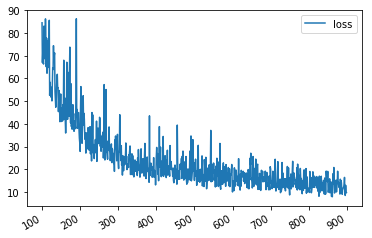

In [8]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float)[100:].plot(subplots=True)

# Visualize

In [9]:
it = iter(pikachu_dl)


Text(0.5,1,'score tensor([0.3994, 0.3994, 0.3504, 0.3504, 0.3499, 0.3499, 0.3238, 0.3238, 0.3037,\n        0.3037], grad_fn=<IndexBackward>)')

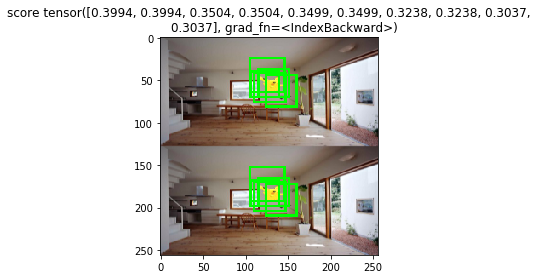

In [10]:
from torchvision.transforms import Resize, ToPILImage, ToTensor

b = next(it)

im = ToTensor()(Resize((256, 256))(ToPILImage()(torch.cat([b[0][0], b[0][0]], dim=1))))
image = im.unsqueeze(0)

enc = DataEncoder(anchor_areas=[30*30, 50*50, 90*90])
loc_pred, cls_pred = model(image.cuda())

i = 0
bbspred, labelpred, score  = enc.decode(
    loc_pred[i].float().cpu(), 
    cls_pred[i].float().cpu(), 
    torch.Tensor([256, 256]).float().cpu()
)

image_to_show = np.moveaxis(
    image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))

image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(score))

### Exercises

-  Load a custom image with pikachu( or many ) and try to make predictiosn with the network and visualize the result
-  Can you think of anything that could confuse our detector? yellow dots ?
- Currently the code is not really modular, try to make it nice by splitting it into logical parts
    - Base feature extractor Module
    - Head Creator module
- Currently the detection/cls HEADS are very simple (just one CONV layer) they can be more complex. Try using more convolutions, check other architectures how its done

- Can you use our network to train using some new data for instance:
    - https://www.kaggle.com/tomluther/ships-in-google-earth
    - https://www.kaggle.com/aruchomu/data-for-yolo-v3-kernel
    - https://www.kaggle.com/dataturks/face-detection-in-images
    - https://www.kaggle.com/dataturks/face-dataset-with-age-emotion-ethnicity  
 You will need to create a data loader/data sets similar as we did for the pikachu loader. 
